<a href="https://colab.research.google.com/github/afrojaakter/Surrogate-Based-Optimization/blob/main/GaussianProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Gaussian Process (GP)
GP is a powerful supervised learning method. 
- Performs well on small dataset
- highly predictable
- automatically estimate the prediction uncertaintly

GP model prediction f(x) at a location x is not a deterministic value, but rather a random variable following a normal distribution, i.e., f(x) ~ N(μ(x), σ²(x)). 

In [1]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=a91a95e24a7a6cc3e17b695e9a89c1d284169810bc921e080cbcbd2fd59dd39d
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

plt.rcParams.update({'font.size': 18})
%matplotlib inline

- ```scipy.optimize.minimize```: to perform optimization;
-```scipy.optimize.Bounds```: to specify parameter bounds for optimization;
-```pyDOE.lhs```: to generate random starting points for the optimizer. Here, we adopt a Latin Hypercube sampling approach because it is good at generating evenly distributed random samples.

Correlation matrix for 2 features X1 and X2:

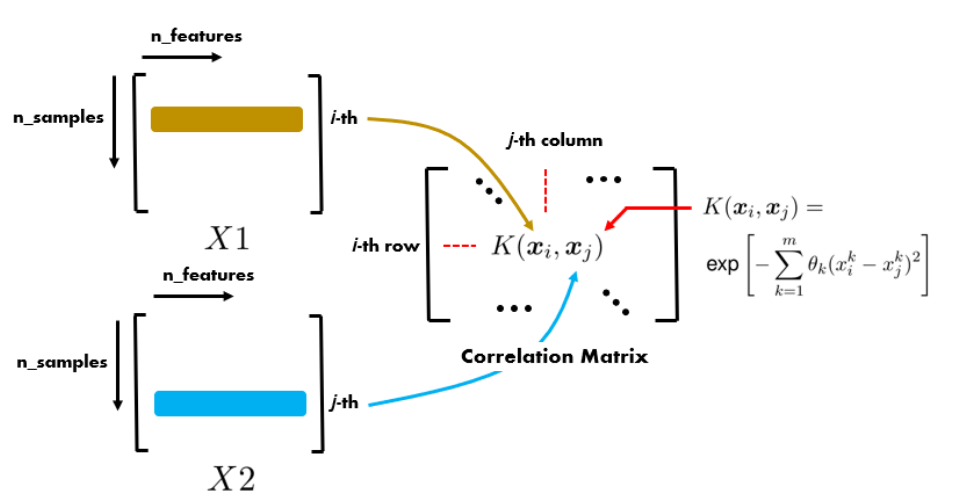

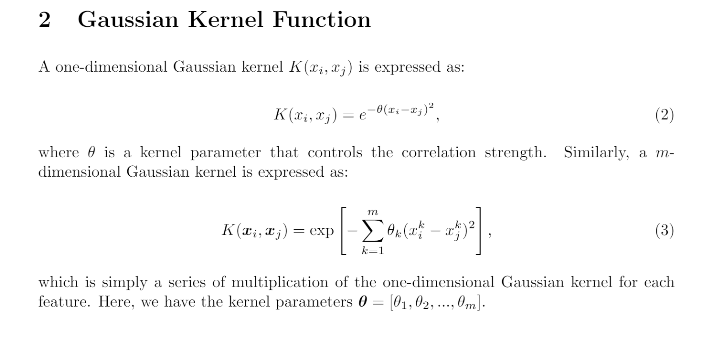

### GP model parameters
A working GP model requires a mean function $\mu(x)$, the process variance $\sigma^2$ and the kernel parameter vecotr $\theta$. In practice $\mu(x)$ is assumed to be constant, i.e., $\mu(x) = \mu$. This process simplifies the computation and doesn't hurt the model accuracy much. Here, I will consider a constant mean.

So, traning a GP model means estimating $\mu, \sigma^2$ and $\theta$. To do that we will introduce maximul likelihood estimation. 


###Maximul likelihood estimation (MLE)
MLE aproach works by finding a specific combination of $\mu, sigma^2$ and $\theta$ such that the likelihood of observing the labels $(y_1, y_2, ..., y_n)$ of the training instances $(x_1, x_2,...,x_n)$ is miximized. 

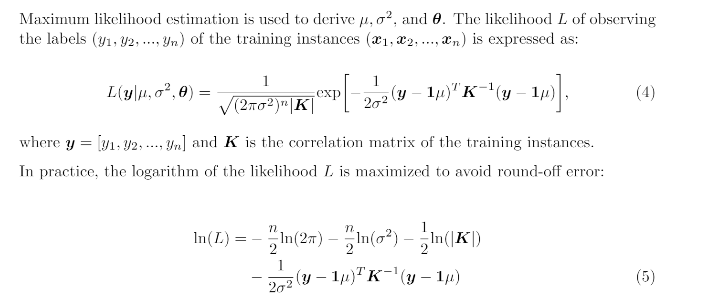

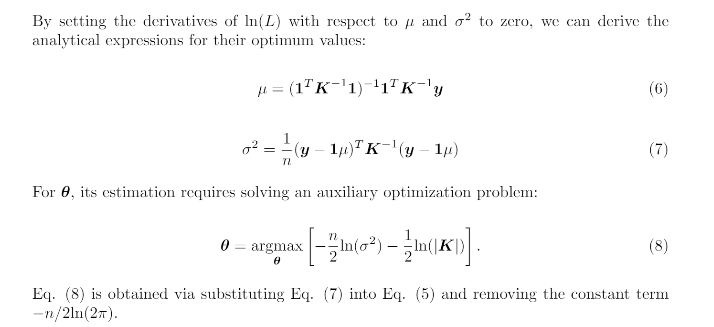

 from an implementation point of view, it is beneficial to search for θ on a logarithmic scale to accelerate the convergence of the optimization algorithm. Therefore, in the following code, we will be optimizing (μ, σ², and 10^θ). A suitable search range for θ is [-3, 2], which translates to a correlation length varying between 0.001 and 100.

###GP model prediction
Our goal is to predict the underlying function value at a test site $x^*$. We denote the prediction as $f^*$.

we know  prediction $f^*$ is not a deterministic value but rather a random variable following a Gaussian distribution.

This result is actually obtained by computing the distribution of f* conditioned on y. In Bayesian language, we are computing the posterior distribution of f*.

1. We will start from the joint distribution of f* and y, i.e., P( y, f*).

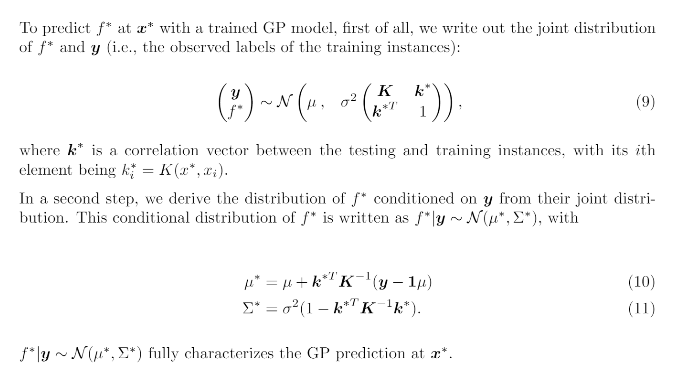

In a second step, we derive P( f*| y ), which describes how f* is distributed given the observed labels y.

###Training A GP Model

In [3]:
%matplotlib inline

class GaussianProcess:
    """A Gaussian Process class for creating and exploiting  
    a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer
    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        
        Input
        -----
        X1, X2: 2D arrays, (n_samples, n_features)
        theta: array, correlation legnths for different dimensions
        
        Output
        ------
        K: the correlation matrix
        """
        K = np.zeros((X1.shape[0],X2.shape[0]))
        for i in range(X1.shape[0]):
            K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
            
        return K
    
    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()
    
    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)

    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE

###Test function
1D test: $$ y = (7x - 2)^2sin(12x - 4), x \in [0, 1]$$

To train a GP model, we select 8 training instances that distribute within [0, 1] range.

In the code snippet below, we first create a training and a test dataset. Then, we initiate an ```GaussianProcess``` instance and adopt an “L-BFGS-B” algorithm to find the optimum θ. Since we are using a multi-start optimization strategy, we want the optimizer to run 10 times by using a different initial point each time. After training the model on the training dataset, the model is used to predict the test data labels.


(-20.0, 20.0)

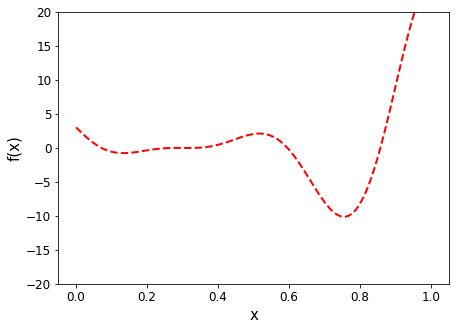

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 18})

def Test_1D(X):
    """1D Test Function"""
    
    y = (X*7-2)**2*np.sin(X*12-4)
    
    return y
# Display the function to be approximated
fig, ax = plt.subplots(figsize=(7,5))

X = np.linspace(0.0, 1, 100).reshape(-1,1)
y = Test_1D(X)

ax.plot(X, y,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-20,20])

In [5]:
from pyDOE import *
# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8,0.9, 1], ndmin=2).T
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

# GP model training
GP = GaussianProcess(n_restarts=10, optimizer='L-BFGS-B')
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

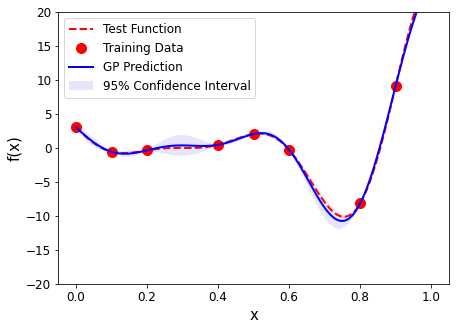

In [6]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.95*np.sqrt(y_pred_SSqr), 
                y_pred+1.95*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Confidence Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-20,20])
ax.legend(loc="upper left",prop={'size': 12});

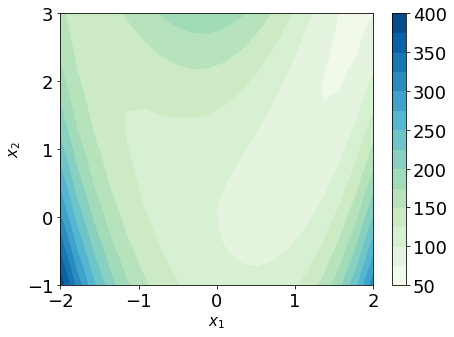

In [7]:
def Test_2D(X):
    """2D Test Function"""
    
    y = (10-X[:,0])**2 + 10*(X[:,1]-X[:,0]**2)**2
    
    return y
    
# Visualizing the test function
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y = Test_2D(X)

fig, ax = plt.subplots(figsize=(7,5))
h = ax.contourf(X1, X2, y.reshape(20,-1), levels=15, cmap='GnBu')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
plt.colorbar(h);

In [8]:
# Training data
sample_num = 25
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

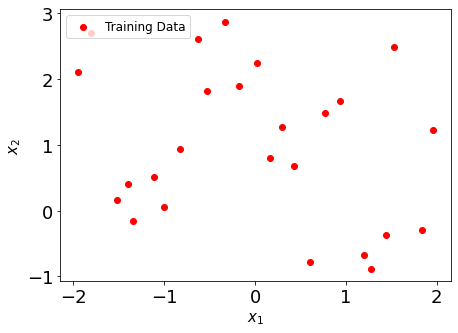

In [9]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

In [10]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GaussianProcess(n_restarts=10, optimizer='L-BFGS-B'))])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('GP', <__main__.GaussianProcess object at 0x7fd5efbd00d0>)],
         verbose=False)

In [11]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

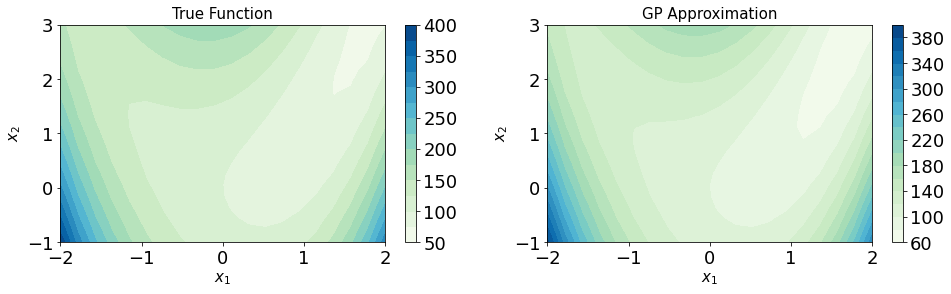

In [12]:
# Post-processing - Contour plot
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 2, figsize=(16,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])


In [14]:
# Assess accuracy score
pipe.score(X_test, y_test)

0.8419831217465292

The advantages of Gaussian processes are:

- Performs well on low dimensional data
- The prediction interpolates the observations.
- The prediction is probabilistic (Gaussian) so that one can compute empirical confidence intervals and decide based on those if one should refit the prediction in some region of interest.



The disadvantages of Gaussian processes include:

- They are not sparse, i.e., they use the whole samples/features information to perform the prediction.

- They lose efficiency in high dimensional spaces – namely when the number of features exceeds a few dozens.

Reference: https://towardsdatascience.com/implement-a-gaussian-process-from-scratch-2a074a470bce#60fd